Hi! I am  [Jean-Nicolas Jérémie](https://github.com/JNJER) and the goal of this benchmark is to offer a comparison between differents pre-trained image recognition's networks based on the [Imagenet](http://image-net.org/) dataset wich allows to work on naturals images for $1000$ labels. These different networks tested here are taken from the `torchvision.models` library : `AlexNet`, `VGG16`, `MobileNetV2` and `ResNet101`.

Our use case is to measure the performance of a system which receives a sequence of images and has to make a decision as soon as possible, hence with `batch_size=1`. Specifically, we wish also to compare different computing architectures such as CPUs, desktop GPUs or other more exotic platform such as the Jetson TX2 (experiment 1). Additionally, we will implement some image transformations as up/down-sampling (experiment 2) or transforming to grayscale (experiment 3) to quantify their influence on the accuracy and computation time of each network.

In this notebook, I will use the [Pytorch](https://pytorch.org/) library for running the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This notebook was done during a master 1 internship at the Neurosciences Institute of Timone (INT) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/). It is curated in the following [github repo](https://github.com/JNJER/2020-06-26_fast_and_curious).

<!-- TEASER_END -->


# Initialization of the benchmark

Our coding strategy is to build up a small libray as a package of scripts in the `DCNN_benchmark` folder and to run all calls to that library from this notebook. This organization will be useful to run on specific hardware such as the Jetson card on the one hand and to visualize results in the notebook, on the other hand.

In [1]:
%matplotlib inline
%mkdir -p DCNN_benchmark

## Importing libraries; definition of the dataset

In [2]:
%%writefile DCNN_benchmark/init.py

# Importing libraries
import os
import time 
from time import strftime,gmtime
import json
import time 
import numpy as np
import imageio
from numpy import random
from torchvision.datasets import ImageFolder
# to plot
import matplotlib.pyplot as plt
# to store results
import pandas as pd

# figure's variables
fig_width = 20
phi = (np.sqrt(5)+1)/2 # golden ratio
phi = phi**2
colors = ['b', 'r', 'k','g']

# host & date's variables 
# HOST = os.uname()[1]
HOST = 'jnjer-HP-Pavilion-Notebook'
HOST = 'fortytwo'
#datetag = strftime("%Y-%m-%d", gmtime()) 
datetag = '2020-08-27'

#dataset configuration

image_size = 256 # default image resolution
image_sizes = 2**np.arange(6, 10) # resolutions explored in experiment 2

N_images_per_class = 10
#i_labels = random.randint(1000, size=(N_labels)) # Random choice
i_labels = [409, 530, 892, 487, 920, 704, 879, 963, 646, 620 ] # Pre-selected classes
N_labels = len(i_labels)

id_dl = ''
root = 'data'
folder = 'imagenet_classes_100'
path = os.path.join(root, folder) # data path

with open('ImageNet-Datasets-Downloader/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
labels[0].split(', ')
labels = [label.split(', ')[1].lower().replace('_', ' ') for label in labels]

class_loader = 'ImageNet-Datasets-Downloader/imagenet_class_info.json'
with open(class_loader, 'r') as fp: # get all the classes on the data_downloader
    name = json.load(fp)

# a reverse look-up-table giving the index of a given label (within the whole set of imagenet labels)
reverse_labels = {}
for i_label, label in enumerate(labels):
    reverse_labels[label] = i_label
# a reverse look-up-table giving the index of a given i_label (within the sub-set of classes)
reverse_i_labels = {}
for i_label, label in enumerate(i_labels):
    reverse_i_labels[label] = i_label


def pprint(message):
    print('-'*len(message))
    print(message)
    print('-'*len(message))

pprint('List of Pre-selected classes')
# choosing the selected classes for recognition
for i_label in i_labels: 
    print('label', i_label, '=', labels[i_label])
    for key in name:
        if name[key]['class_name'] == labels[i_label]:
            id_dl += key + ' '
pprint('label IDs = ' + str(id_dl) )

Overwriting DCNN_benchmark/init.py


In [3]:
%run DCNN_benchmark/init.py

----------------------------
List of Pre-selected classes
----------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
----------------------------------------------------------------------------------------------------------------
label IDs = n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 
----------------------------------------------------------------------------------------------------------------


In [4]:
if HOST == 'fortytwo':
    do_local = False 
    python_exec = "KMP_DUPLICATE_LIB_OK=TRUE python3"
else :
    do_local =True

## Download of example images from ImageNet :

We use an [ImageNet dataloader](https://github.com/laurentperrinet/ImageNet-datasets-downloader) to populate a dataset based on the pre-selected or randoms classes listed in the `DCNN_benchmark/init.py` file.

In [5]:
scriptname = 'DCNN_benchmark/dataset.py'

In [6]:
%%writefile {scriptname}

from DCNN_benchmark.init import *

# check if the folder exist
if os.path.isdir(path):
    list_dir = os.listdir(path)
    print("The folder " , folder, " already exists, it includes: ", list_dir)
    
# no folder, creating one 
else :
    print(f"No existing path match for this folder, creating a folder at {path}")
    os.makedirs(path)

# if the folder is empty, download the images using the ImageNet-Datasets-Downloader
if len(list_dir) < N_labels : 
    print('This folder do not have anough classes, downloading some more') 
    cmd =f"python3 ImageNet-Datasets-Downloader/downloader.py -data_root {root} -data_folder {folder} -images_per_class {N_images_per_class} -use_class_list True  -class_list {id_dl} -multiprocessing_workers 0"
    print('Command to run : ', cmd)
    os.system(cmd) # running it
    list_dir = os.listdir(path)
    
elif len(os.listdir(path)) == N_labels :
    print(f'The folder already contains : {len(list_dir)} classes')
          
else : # if there are to many folders delete some
    print('The folder have to many classes, deleting some')
    for elem in os.listdir(path):
        contenu = os.listdir(f'{path}/{elem}')
        if len(os.listdir(path)) > N_labels :
            for x in contenu:
                os.remove(f'{path}/{elem}/{x}') # delete exces folders
            try:
                os.rmdir(f'{path}/{elem}')
            except:
                os.remove(f'{path}/{elem}')
    list_dir = os.listdir(path)
    print("Now the folder " , folder, f" contains :", os.listdir(path))

Overwriting DCNN_benchmark/dataset.py


In [7]:
if do_local:
    %run {scriptname}
else:
    !python3 {scriptname}

----------------------------
List of Pre-selected classes
----------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
----------------------------------------------------------------------------------------------------------------
label IDs = n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 
----------------------------------------------------------------------------------------------------------------
The folder  imagenet_classes_100  already exists, it includes:  ['digital clock', 'analog clock', 'wall clock', 'parking meter', 'cellular telephone', 'maze', 'umbrella', 'laptop', 'pizza', 'traffic light']
The folder already contains : 10 classes


## Pre-trained network's import

Here we worked on four differents pre-trained networks `Alexnet`, `Mobilenet`, `Resnet101` and `VGG16`:

In [8]:
scriptname = 'DCNN_benchmark/models.py'

In [9]:
%%writefile {scriptname}

from DCNN_benchmark.init import *

import torch
import torchvision
import torchvision.transforms as transforms

# transform function for input's image processing
transform = transforms.Compose([
    transforms.Resize(int(image_size)),      # Resize the image to image_size x image_size pixels size.
    transforms.CenterCrop(int(image_size-20)),  # Crop the image to (image_size-20) x (image_size-20) pixels around the center.
    transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type.
    transforms.Normalize(        # Normalize the image by adjusting
    mean=[0.485, 0.456, 0.406],  #  its average and
    std=[0.229, 0.224, 0.225]    #  its standard deviation at the specified values.              
    )])


image_dataset = ImageFolder(path, transform=transform) # save the dataset

# imports networks with weights
models = {} # get model's names

models['alex'] = torchvision.models.alexnet(pretrained=True)
models['vgg'] = torchvision.models.vgg16(pretrained=True)
models['mob'] = torchvision.models.mobilenet_v2(pretrained=True)
models['res'] = torchvision.models.resnext101_32x8d(pretrained=True)


# Select a device (CPU or CUDA)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for name in models.keys():
    models[name].to(device)

Overwriting DCNN_benchmark/models.py


In [10]:
%run {scriptname}

----------------------------
List of Pre-selected classes
----------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
----------------------------------------------------------------------------------------------------------------
label IDs = n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 
----------------------------------------------------------------------------------------------------------------


# Experiment 1: Image processing and recognition for differents labels :

To recover the classification confidence of the models according to the classes on which they have been trained, i.e. the $1000$ classes of the `ImageNet` library, the `softmax` mathematical function is added at the last layer of the networks. The `softmax` function is a function which takes a vector of real values (here represented by a 1-D tensor) of dimension `K` (here `K=1000` trained classes) and returns for each of these values a normalized propability between $0$ and $1$ with a sum equal to $1$. Thus, all the classes are represented in the final vector and a low probability would then be a proof of absence for instance. A careful reading of the original [imagenet paper](http://image-net.org/papers/imagenet_cvpr09.pdf) shows that this probability reflects the response of users to questions such as "Is there a *Burmese cat* in the images?" when presented an image (retrieved on internet) which is likely to include "Burmese cat".

Here, we are interested in a sub-set of such classes. Nevertheless, the recognition being carried out on so-called "natural" images of the irrelevant classes could "mask" the recognition of those of interest. To reduce this effect, we have applied a slight modification to the output `softmax` function, by assuming that we know *a priori* that the image belongs to one (and only one) category from the sub-set, but that we do not know which one. As a consequence, it does not recover a vector of $K = 1000$ but of $K = N_{labels}$. As a consequence, the probabilities obtained would correspond to a confidence of classification discriminating only the classes of interest and can be compared to a chance level of $1 / N_{labels}$. 

For further statistical analyses, we extract these differents factors (like the accuracy and the processing time for differents datasets at differents resolution) in a `pandas` object. 

In [11]:
scriptname = 'experiment_basic.py'

In [12]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_benchmark.models import *
filename = f'results/{datetag}_results_1_{HOST}.json'

try:
    df = pd.read_json(filename)
except:
    df = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device']) 
    i_trial = 0
    
    # image preprocessing
    for i_image, (data, label) in enumerate(image_dataset):
        for name in models.keys():
            model = models[name]
            model.eval()
            tic = time.time()
            out = model(data.unsqueeze(0).to(device)).squeeze(0)
            percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
            _, indices = torch.sort(percentage, descending=True)           
            dt = time.time() - tic
            i_label_top = reverse_labels[image_dataset.classes[label]]
            perf_ = percentage[reverse_i_labels[i_label_top]].item()            
            df.loc[i_trial] = {'model':name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                               'label':labels[i_label_top], 'i_label':i_label_top, 
                               'i_image':i_image, 'filename':image_dataset.imgs[i_image][0], 'device':str(device)}
            print(f'The {name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds')
            i_trial += 1
    df.to_json(filename)

Overwriting experiment_basic.py


In [13]:
if do_local:
    %run {scriptname}
else:
    !{python_exec} {scriptname}

----------------------------
List of Pre-selected classes
----------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
----------------------------------------------------------------------------------------------------------------
label IDs = n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 
----------------------------------------------------------------------------------------------------------------


## Image recognition on differents labels display :

Here we collect our results, we can already display all the data in a table 

In [14]:
filename = f'results/{datetag}_results_1_{HOST}.json'
df = pd.read_json(filename)
df

model       perf        fps      time         label  i_label  i_image  \
0     alex  30.283058  22.265360  0.044913  analog clock      409        0   
1      vgg  62.287682   2.338869  0.427557  analog clock      409        0   
2      mob  42.539902  18.122563  0.055180  analog clock      409        0   
3      res  70.461670   1.496365  0.668286  analog clock      409        0   
4     alex   7.313114  14.566287  0.068652  analog clock      409        1   
...    ...        ...        ...       ...           ...      ...      ...   
2335   res  81.857353   1.745690  0.572839    wall clock      892      583   
2336  alex  76.701584   9.910013  0.100908    wall clock      892      584   
2337   vgg  78.698418   2.124301  0.470743    wall clock      892      584   
2338   mob  46.693691  13.741139  0.072774    wall clock      892      584   
2339   res  83.952156   1.785157  0.560175    wall clock      892      584   

                                               filename device  
0     data/imagenet_classes_100/analog clock/1021913...    cpu  
1     data/imagenet_classes_100/analog clock/1021913...    cpu  
2     data/imagenet_classes_100/analog clock/1021913...    cpu  
3     data/imagenet_classes_100/analog clock/1021913...    cpu  
4     data/imagenet_classes_100/analog clock/1036540...    cpu  
...                                                 ...    ...  
2335  data/imagenet_classes_100/wall clock/944534279...    cpu  
2336  data/imagenet_classes_100/wall clock/97880360_...    cpu  
2337  data/imagenet_classes_100/wall clock/97880360_...    cpu  
2338  data/imagenet_classes_100/wall clock/97880360_...    cpu  
2339  data/imagenet_classes_100/wall clock/97880360_...    cpu  

[2340 rows x 9 columns]

A display of the differents computation time of each models on the same dataset for the sequence of trials :

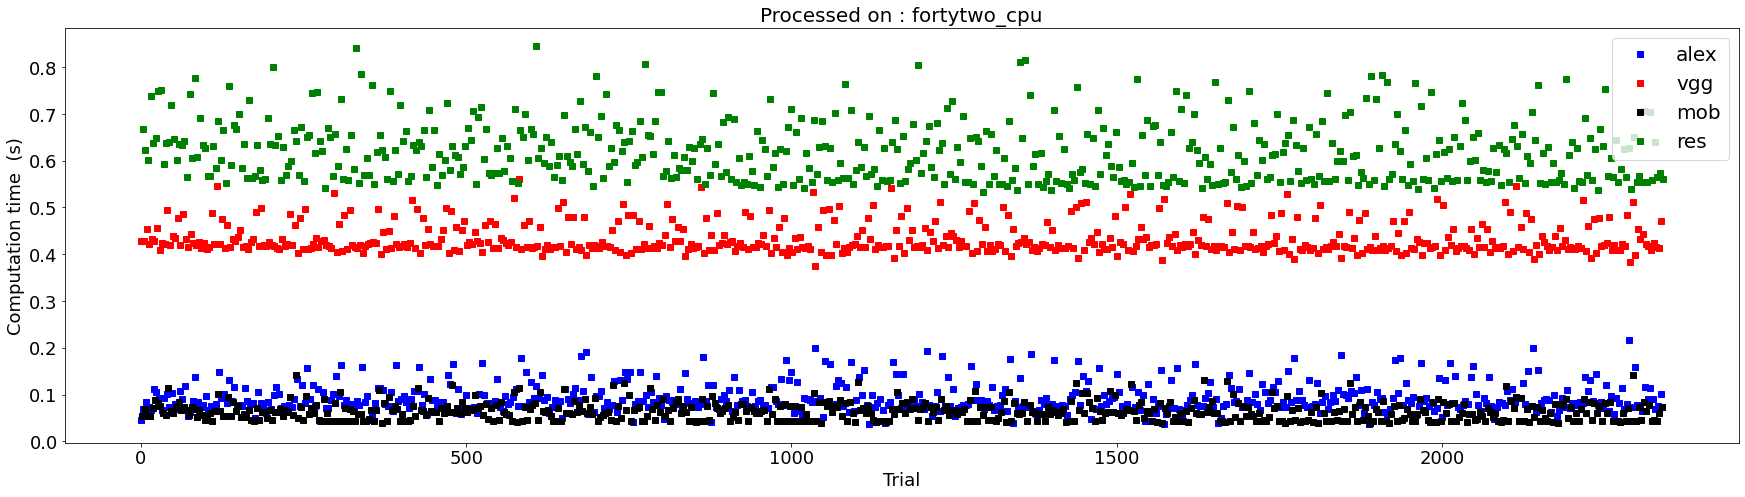

In [15]:
fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for color, name in zip(colors, models.keys()):
    axs.set_ylabel('Computation time  (s)', size= 18)
    axs.set_xlabel('Trial', size= 18)
    #axs.set_ylim(0, 1)
    df[df['model']==name]['time'].plot(label=name, color=color, marker='s', lw=0)
    axs.legend(loc=0, fontsize = 20)
    axs.set_title('Processed on : '  + HOST + '_' + str(df['device'][0]), size = 20)

This graph shows the frequency of the classification performance for our four models. 

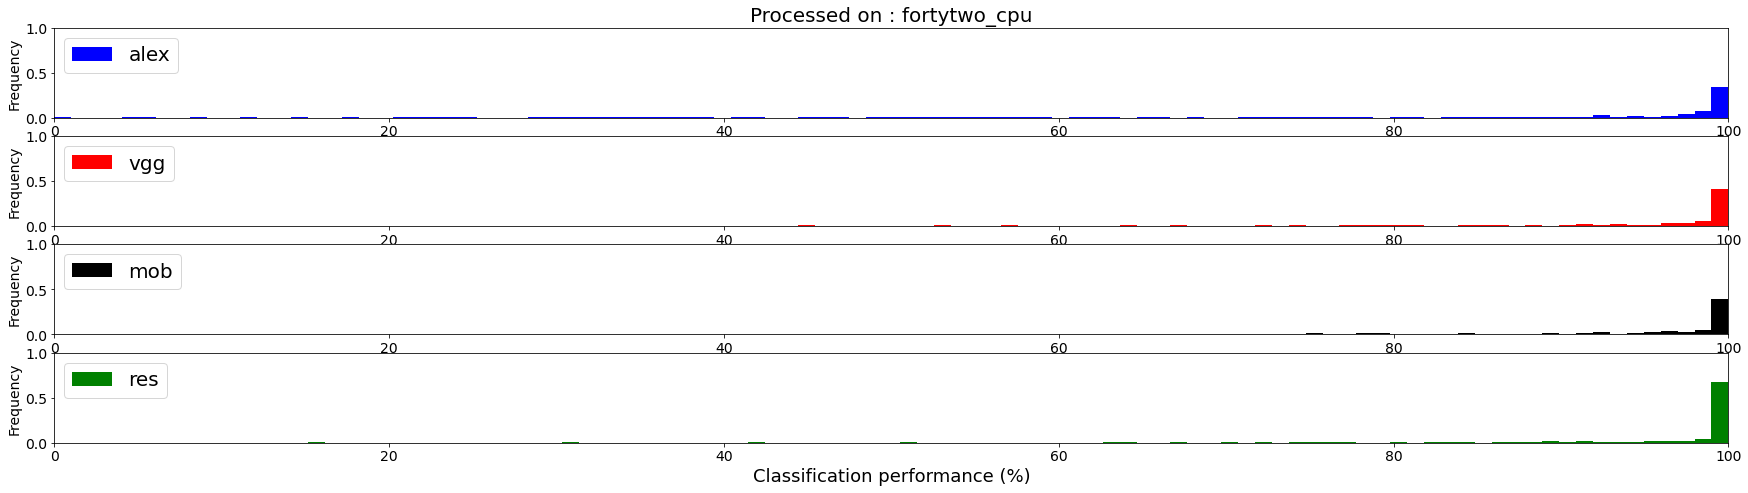

In [16]:
fig, axs = plt.subplots(len(models), 1, figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for ax, color, name in zip(axs, colors, models.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df[df['model']==name]['perf'].plot.hist(bins=np.linspace(0, 100, 100), lw=1, label=name,ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize = 20)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification performance (%)', size= 18)
axs[0].set_title('Processed on : ' + HOST + '_' + str(df['device'][0]), size = 20);

Here we display the 64 *worsts* classification performance, all model combined : 

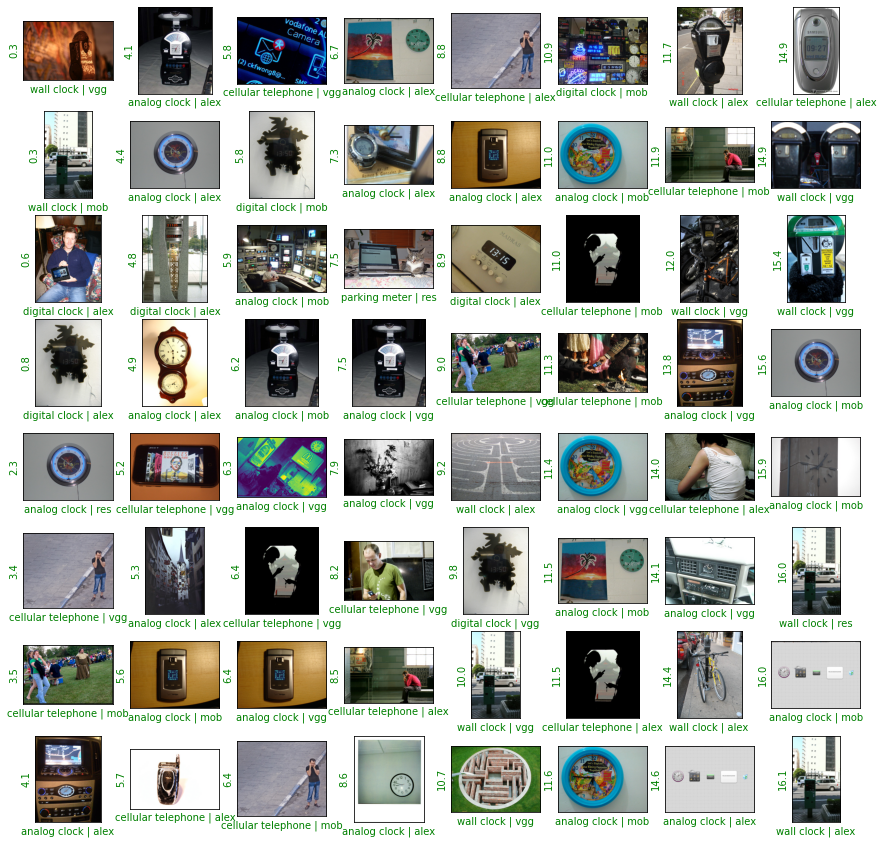

In [17]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(21, 21))
for i, idx in enumerate(df["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_dataset.imgs[df.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df.loc[idx]['label'] + ' | ' + df.loc[idx]['model'], color='g')
    perf_ = df.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

To make it even clearer we extracted a specific median for each models : 

Accuracy's median

In [18]:
for name in models.keys():
    med_perf = np.median(df[df['model']==name]["perf"])
    print(f'For the {name} model, the median clasification performance =  {med_perf:.2f} %' )

For the alex model, the median clasification performance =  95.60 %
For the vgg model, the median clasification performance =  97.13 %
For the mob model, the median clasification performance =  96.41 %
For the res model, the median clasification performance =  99.97 %


Computation time 's median

In [19]:
for name in models.keys():
    med_perf = np.median(df[df['model']==name]["time"])
    print(f'For the {name} model, the median computation time  =  {med_perf:.3f} s')

For the alex model, the median computation time  =  0.086 s
For the vgg model, the median computation time  =  0.420 s
For the mob model, the median computation time  =  0.062 s
For the res model, the median computation time  =  0.609 s


Frame per second's median

In [20]:
for name in models.keys():
    med_perf = np.median(df[df['model']==name]["fps"])
    print(f'For the {name} model, the median fps  =  {med_perf:.3f} Hz' )

For the alex model, the median fps  =  11.637 Hz
For the vgg model, the median fps  =  2.382 Hz
For the mob model, the median fps  =  16.218 Hz
For the res model, the median fps  =  1.641 Hz


To summarize, the model which displays the best accuracy is the `Resnet_101` network. However, the cost for such a high accuracy is reflected in the computation time as the `Resnet_101` also presents the higher computation time to process an image. Note that the `Mobilenet` network shows a good accuracy (>95%), while keeping the computation time reasonable. This results into a higher frame rate (images processed per second) that allows near to real-time recognition on a standard camera such as a webcam. 

# Experiment 2: Image processing and recognition for differents resolutions :

Let's now study that same performance indicators at different image resolutions.

In [21]:
scriptname = 'experiment_downsample.py'

In [22]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_benchmark.models import *
filename = f'results/{datetag}_results_2_{HOST}.json'

# Output's set up
try:
    df_downsample = pd.read_json(filename)
except:
    df_downsample = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'image_size', 'filename', 'device']) 
    i_trial = 0

    # image preprocessing
    for image_size in image_sizes:
        image_size = int(image_size)
        transform = transforms.Compose([  # Downsampling function on the input
        transforms.Resize(image_size),      #  Resize the image to image_size x image_size pixels size.
        transforms.CenterCrop(image_size),  # Crop the image to image_size x image_size pixels around the center.
        transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type.
        transforms.Normalize(        # Normalize the image by adjusting its average and
                                     # its standard deviation at the specified values.
        mean=[0.485, 0.456, 0.406],                
        std=[0.229, 0.224, 0.225]                  
        )])
        image_dataset_downsample = ImageFolder(path, transform=transform) # Get the downsample dataset
        print(f'Résolution de {image_size}')
        # Displays the input image of the model 
        for i_image, (data, label) in enumerate(image_dataset_downsample):
            for name in models.keys():
                model = models[name]
                model.eval()
                tic = time.time()
                out = model(data.unsqueeze(0).to(device)).squeeze(0)
                percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
                _, indices = torch.sort(percentage, descending=True)           
                dt = time.time() - tic
                i_label_top = reverse_labels[image_dataset_downsample.classes[label]]
                perf_ = percentage[reverse_i_labels[i_label_top]].item()            
                df_downsample.loc[i_trial] = {'model':name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_dataset.imgs[i_image][0], 'image_size': image_size, 'device':str(device)}
                print(f'The {name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds')
                i_trial += 1
        df_downsample.to_json(filename)

Overwriting experiment_downsample.py


In [23]:
if do_local:
    %run {scriptname}
else:
    !{python_exec} {scriptname}

----------------------------
List of Pre-selected classes
----------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
----------------------------------------------------------------------------------------------------------------
label IDs = n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 
----------------------------------------------------------------------------------------------------------------


## Image recognition on differents resolutions display :

Here, again, we collect our results, and display all the data in a table 

In [24]:
filename = f'results/{datetag}_results_2_{HOST}.json'
df_downsample = pd.read_json(filename)
df_downsample

model       perf        fps      time         label  i_label  i_image  \
0     alex   9.343772  31.227368  0.032023  analog clock      409        0   
1      vgg  99.346138  15.442548  0.064756  analog clock      409        0   
2      mob  12.842411  37.820936  0.026440  analog clock      409        0   
3      res  99.999985   5.562413  0.179778  analog clock      409        0   
4     alex   3.081072  82.794844  0.012078  analog clock      409        1   
...    ...        ...        ...       ...           ...      ...      ...   
9355   res  73.330170   0.463644  2.156827    wall clock      892      583   
9356  alex  66.194016   3.297598  0.303251    wall clock      892      584   
9357   vgg  49.747833   0.566147  1.766327    wall clock      892      584   
9358   mob  43.012997   4.605193  0.217146    wall clock      892      584   
9359   res  41.983994   0.448765  2.228337    wall clock      892      584   

      image_size                                           filename device  
0             64  data/imagenet_classes_100/analog clock/1021913...    cpu  
1             64  data/imagenet_classes_100/analog clock/1021913...    cpu  
2             64  data/imagenet_classes_100/analog clock/1021913...    cpu  
3             64  data/imagenet_classes_100/analog clock/1021913...    cpu  
4             64  data/imagenet_classes_100/analog clock/1036540...    cpu  
...          ...                                                ...    ...  
9355         512  data/imagenet_classes_100/wall clock/944534279...    cpu  
9356         512  data/imagenet_classes_100/wall clock/97880360_...    cpu  
9357         512  data/imagenet_classes_100/wall clock/97880360_...    cpu  
9358         512  data/imagenet_classes_100/wall clock/97880360_...    cpu  
9359         512  data/imagenet_classes_100/wall clock/97880360_...    cpu  

[9360 rows x 10 columns]

Let's display of the accuracy of each models on the same dataset for differents resolutions. Here accuracies are displayed as a violin plot to allow a better representation of the models.

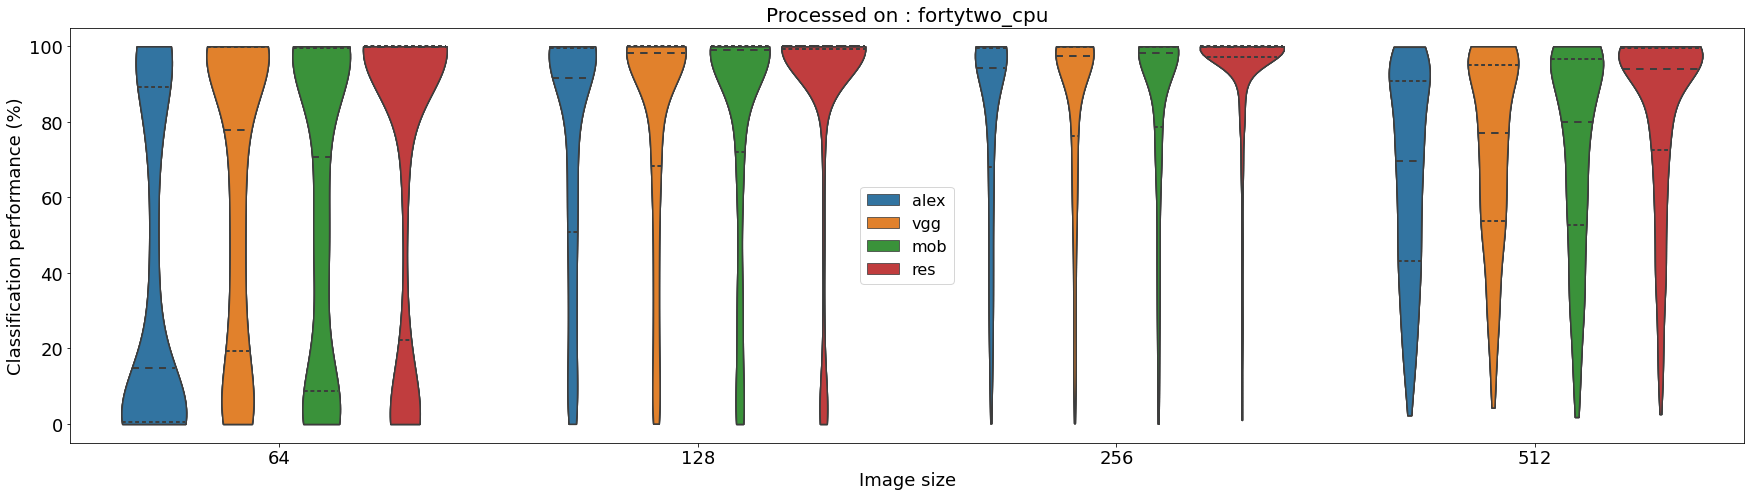

In [25]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, name in zip(colors, models.keys()):
    axs = sns.violinplot(x="image_size", y="perf", data=df_downsample, inner="quartile", hue='model', cut = 0)
    axs.set_title('Processed on : ' + HOST + '_' + str(df_downsample['device'][0]), size=20)
    axs.set_ylabel('Classification performance (%)', size=18)
    axs.set_xlabel('Image size', size=18)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:4], l[:4], loc ='center', fontsize=16);

The 64 worsts classification performance, all models and sizes combined : 

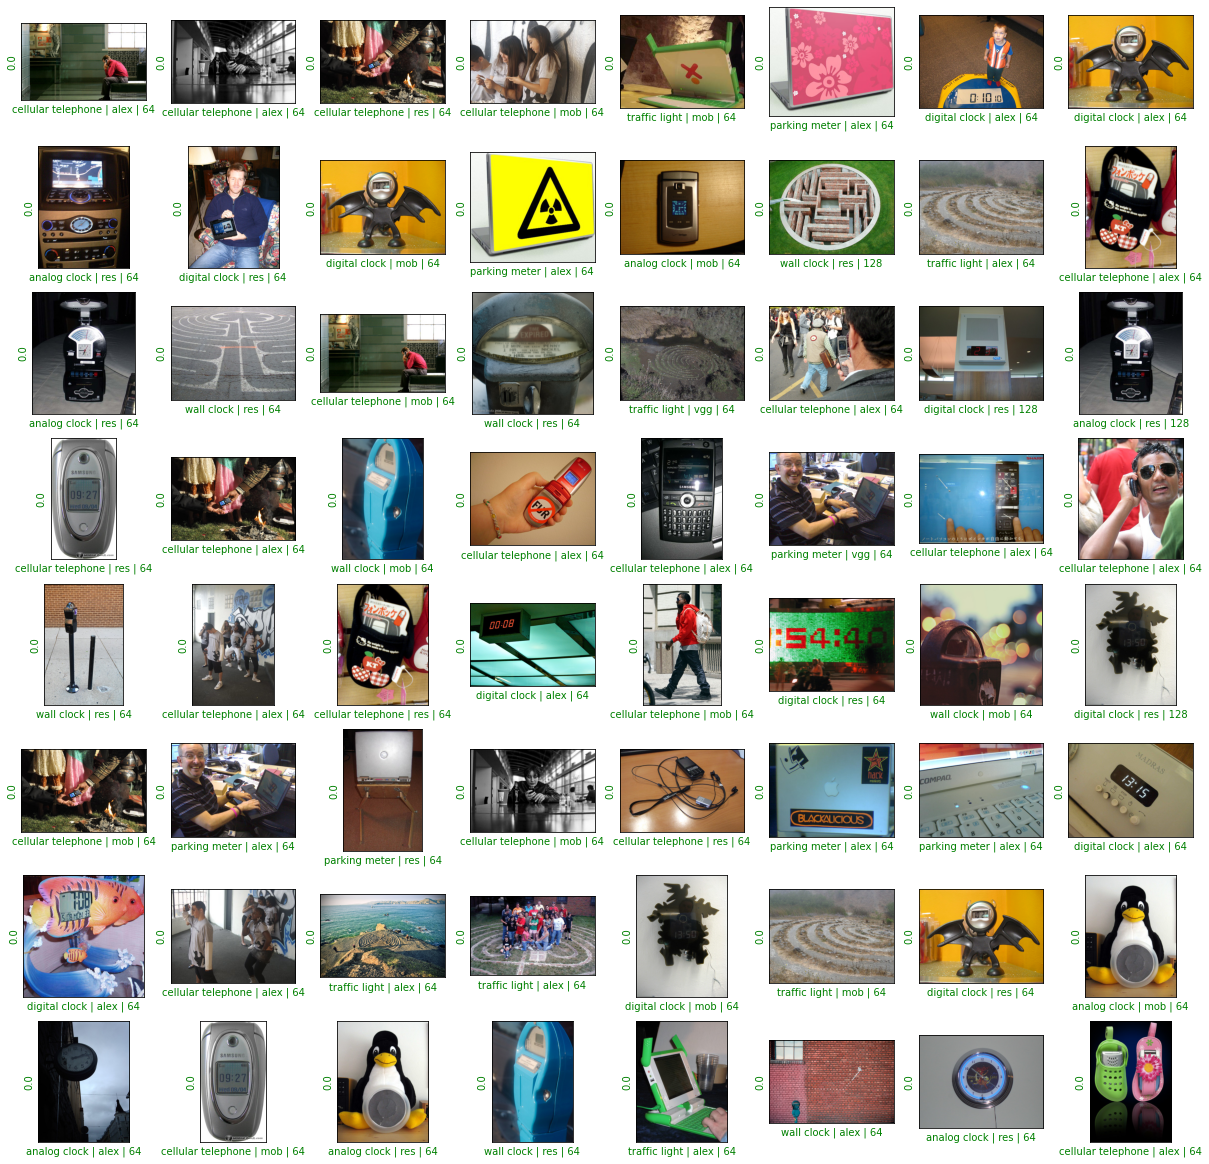

In [46]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(21, 21))
for i, idx in enumerate(df_downsample["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_dataset.imgs[df_downsample.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_downsample.loc[idx]['label'] + ' | ' + df_downsample.loc[idx]['model']+ ' | ' + str(df_downsample.loc[idx]['image_size']), color='g')
    perf_ = df_downsample.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

A display of the differents computation time of each models on the same dataset for differents resolutions :

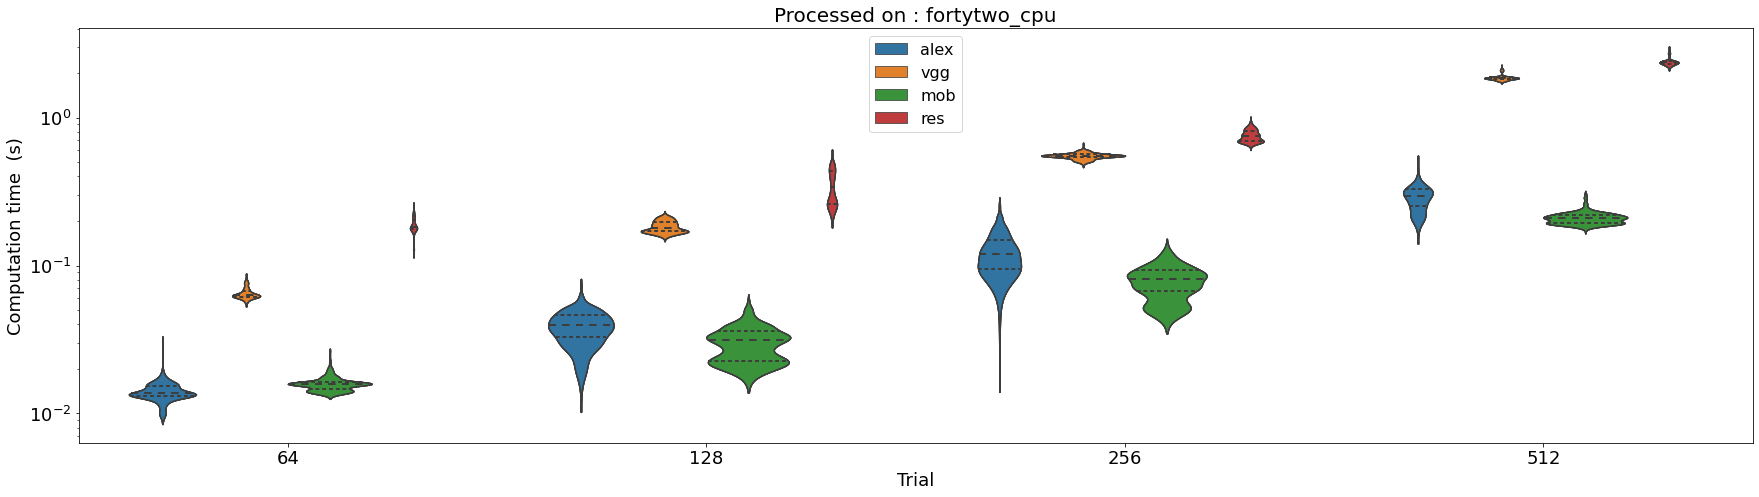

In [27]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, name in zip(colors, models.keys()):
    axs = sns.violinplot(x="image_size", y="time", data=df_downsample, inner="quartile", hue='model')
    axs.set_title('Processed on : ' + HOST + '_' + str(df_downsample['device'][0]), size = 20)
    axs.set_ylabel('Computation time  (s)', size= 18)
    axs.set_xlabel('Trial', size= 18)
    axs.set_yscale('log')
h, l = axs.get_legend_handles_labels()
axs.legend(h[:4], l[:4], loc='upper center', fontsize=16);    

Again, we extracted a specific median for each models : 

In [28]:
for name in models.keys():
    pprint(f'Benchmarking model {name}')
    for image_size in image_sizes:
        med_perf = np.median(df_downsample[(df_downsample['model']==name) & (df_downsample['image_size']==image_size)]["perf"])
        print(f'For size {image_size}, the median clasification performance =  {med_perf:.2f} %' )

-----------------------
Benchmarking model alex
-----------------------
For size 64, the median clasification performance =  14.78 %
For size 128, the median clasification performance =  91.61 %
For size 256, the median clasification performance =  94.34 %
For size 512, the median clasification performance =  69.53 %
----------------------
Benchmarking model vgg
----------------------
For size 64, the median clasification performance =  77.83 %
For size 128, the median clasification performance =  98.26 %
For size 256, the median clasification performance =  97.38 %
For size 512, the median clasification performance =  76.93 %
----------------------
Benchmarking model mob
----------------------
For size 64, the median clasification performance =  70.68 %
For size 128, the median clasification performance =  98.92 %
For size 256, the median clasification performance =  98.37 %
For size 512, the median clasification performance =  80.08 %
----------------------
Benchmarking model res
---

The classification performance does not depend on the host (a priori :-) ) but the timing does (see almso the synthesis below):

In [29]:
for name in models.keys():
    pprint(f'Benchmarking model {name}')
    for image_size in image_sizes:
        med_perf = np.median(df_downsample[(df_downsample['model']==name) & (df_downsample['image_size']==image_size)]["time"])
        print(f'For size {image_size}, the median  computation time =  {med_perf:.2f} s' )

-----------------------
Benchmarking model alex
-----------------------
For size 64, the median  computation time =  0.01 s
For size 128, the median  computation time =  0.04 s
For size 256, the median  computation time =  0.12 s
For size 512, the median  computation time =  0.30 s
----------------------
Benchmarking model vgg
----------------------
For size 64, the median  computation time =  0.06 s
For size 128, the median  computation time =  0.18 s
For size 256, the median  computation time =  0.55 s
For size 512, the median  computation time =  1.85 s
----------------------
Benchmarking model mob
----------------------
For size 64, the median  computation time =  0.02 s
For size 128, the median  computation time =  0.03 s
For size 256, the median  computation time =  0.08 s
For size 512, the median  computation time =  0.21 s
----------------------
Benchmarking model res
----------------------
For size 64, the median  computation time =  0.18 s
For size 128, the median  computatio

In [30]:
for name in models.keys():
    pprint(f'Benchmarking model {name}')
    for image_size in image_sizes:
        med_perf = np.median(df_downsample[(df_downsample['model']==name) & (df_downsample['image_size']==image_size)]["fps"])
        print(f'For size {image_size}, the median fps  =  {med_perf:.3f} Hz' )

-----------------------
Benchmarking model alex
-----------------------
For size 64, the median fps  =  72.491 Hz
For size 128, the median fps  =  25.381 Hz
For size 256, the median fps  =  8.384 Hz
For size 512, the median fps  =  3.384 Hz
----------------------
Benchmarking model vgg
----------------------
For size 64, the median fps  =  15.843 Hz
For size 128, the median fps  =  5.535 Hz
For size 256, the median fps  =  1.810 Hz
For size 512, the median fps  =  0.541 Hz
----------------------
Benchmarking model mob
----------------------
For size 64, the median fps  =  63.291 Hz
For size 128, the median fps  =  31.691 Hz
For size 256, the median fps  =  12.306 Hz
For size 512, the median fps  =  4.783 Hz
----------------------
Benchmarking model res
----------------------
For size 64, the median fps  =  5.471 Hz
For size 128, the median fps  =  2.949 Hz
For size 256, the median fps  =  1.333 Hz
For size 512, the median fps  =  0.424 Hz


The classification performance reduces when the resolution is too low or, surprisingly, higher as the regular size of an input's image (which is trained usually with `128 x 128` pixels). Also, the computation time  seems proportional to the resolution, a higher resolution need a higher delay to compute the image on a CPU. A size of `128 x 128` pixels clearly stands out as an optimal compromise for these models.

# Experiment 3: Image processing and recognition on grayscale images :

In [31]:
scriptname = 'experiment_grayscale.py'

In [32]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_benchmark.models import *
filename = f'results/{datetag}_results_3_{HOST}.json'

# Output's set up
try:
    df_gray = pd.read_json(filename)
except:
    df_gray = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device']) 
    i_trial = 0
    
    # image preprocessing
    transform = transforms.Compose([
    transforms.Grayscale(3),      # convert the image in grayscale
    transforms.Resize(int(image_size)),      # Resize the image.
    transforms.CenterCrop(int(image_size-20)), # Crop the image with a 20 pixels border.
    transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type.
    transforms.Normalize(        # Normalize the image by adjusting its average and
                                 #     its standard deviation at the specified values.
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])
    image_dataset_grayscale = ImageFolder(path, transform=transform) # Get the downsample dataset

    # Displays the input image of the model
    for i_image, (data, label) in enumerate(image_dataset_grayscale):
            for name in models.keys():
                model = models[name]
                model.eval()
                tic = time.time()
                out = model(data.unsqueeze(0).to(device)).squeeze(0)
                percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
                _, indices = torch.sort(percentage, descending=True)           
                dt = time.time() - tic
                i_label_top = reverse_labels[image_dataset_grayscale.classes[label]]
                perf_ = percentage[reverse_i_labels[i_label_top]].item()            
                df_gray.loc[i_trial] = {'model':name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_dataset.imgs[i_image][0], 'device':str(device)}
                print(f'The {name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds')
                i_trial += 1
    df_gray.to_json(filename)

Overwriting experiment_grayscale.py


In [33]:
if do_local:
    %run {scriptname}
else:
    !{python_exec} {scriptname}

----------------------------
List of Pre-selected classes
----------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
----------------------------------------------------------------------------------------------------------------
label IDs = n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 
----------------------------------------------------------------------------------------------------------------


## Image recognition on differents labels with grayscale display :

Collecting all the results, displaying all the data in a table 

In [34]:
filename = f'results/{datetag}_results_3_{HOST}.json'
df_gray = pd.read_json(filename)
df_gray

model       perf        fps      time         label  i_label  i_image  \
0     alex  51.810474  21.962006  0.045533  analog clock      409        0   
1      vgg  60.235466   2.313251  0.432292  analog clock      409        0   
2      mob  46.277802  15.492572  0.064547  analog clock      409        0   
3      res  48.030956   1.532135  0.652684  analog clock      409        0   
4     alex  30.689520  16.094735  0.062132  analog clock      409        1   
...    ...        ...        ...       ...           ...      ...      ...   
2335   res  84.015900   1.830979  0.546156    wall clock      892      583   
2336  alex  59.561760  11.031923  0.090646    wall clock      892      584   
2337   vgg  66.367844   2.516342  0.397402    wall clock      892      584   
2338   mob  47.893414  23.811790  0.041996    wall clock      892      584   
2339   res  57.152008   1.853634  0.539481    wall clock      892      584   

                                               filename device  
0     data/imagenet_classes_100/analog clock/1021913...    cpu  
1     data/imagenet_classes_100/analog clock/1021913...    cpu  
2     data/imagenet_classes_100/analog clock/1021913...    cpu  
3     data/imagenet_classes_100/analog clock/1021913...    cpu  
4     data/imagenet_classes_100/analog clock/1036540...    cpu  
...                                                 ...    ...  
2335  data/imagenet_classes_100/wall clock/944534279...    cpu  
2336  data/imagenet_classes_100/wall clock/97880360_...    cpu  
2337  data/imagenet_classes_100/wall clock/97880360_...    cpu  
2338  data/imagenet_classes_100/wall clock/97880360_...    cpu  
2339  data/imagenet_classes_100/wall clock/97880360_...    cpu  

[2340 rows x 9 columns]

A display of the differents computation time of each models on the same dataset for a single resolution :

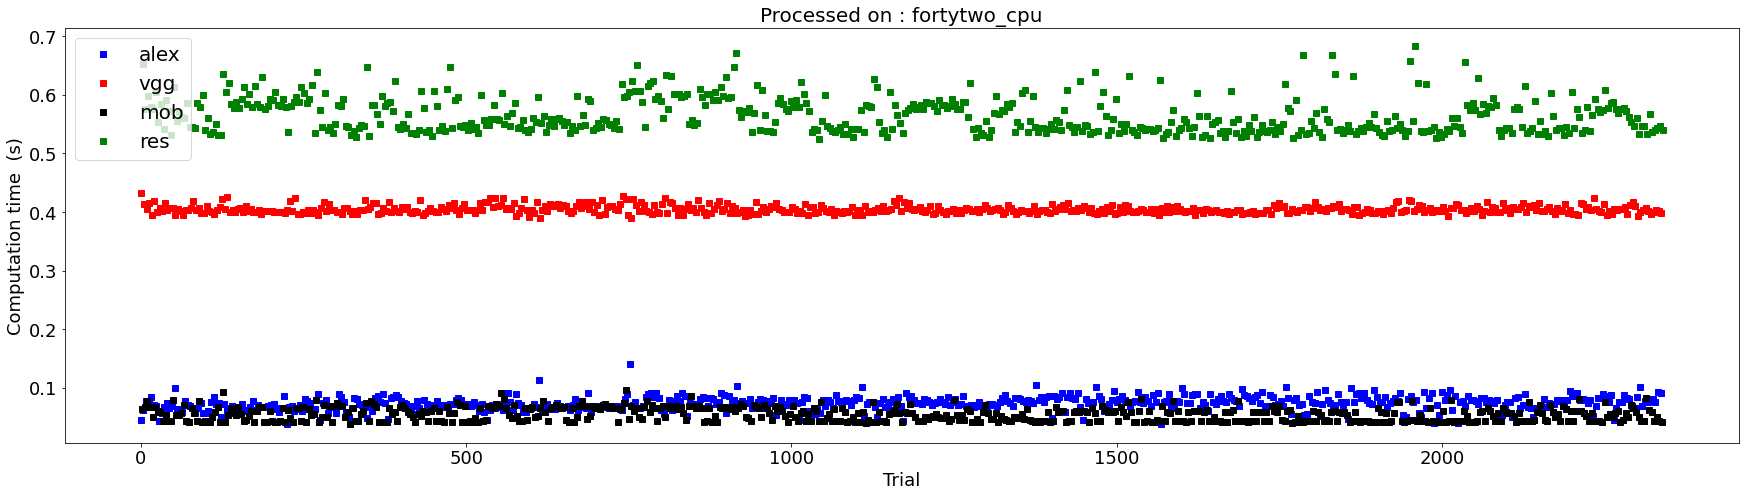

In [35]:
fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for color, name in zip(colors, models.keys()):
    axs.set_ylabel('Computation time  (s)', size= 18)
    axs.set_xlabel('Trial', size= 18)
    df_gray[df_gray['model']==name]['time'].plot(label=name, color=color, marker='s', lw=0)
    axs.legend(loc=0, fontsize = 20)
    axs.set_title('Processed on : ' + HOST + '_' + str(df_gray['device'][0]), size = 20)

A display of the accuracy of each models on the same dataset for a single resolution :

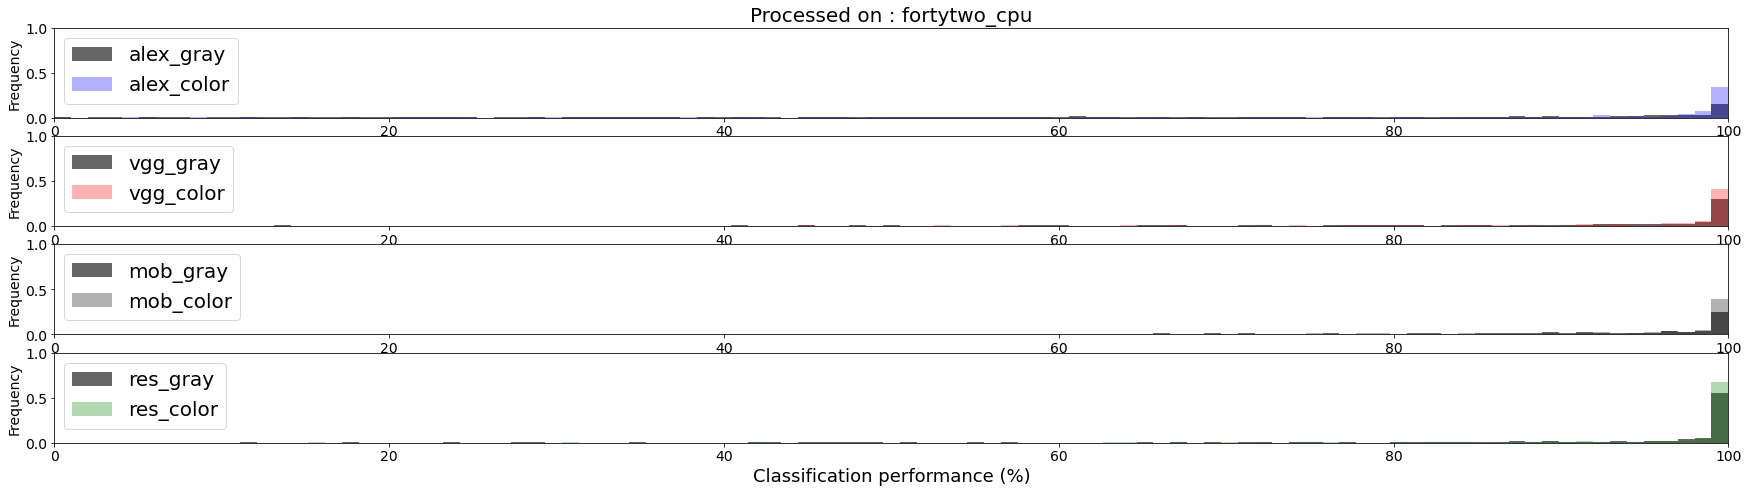

In [36]:
fig, axs = plt.subplots(len(models), 1, figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for ax, color, name in zip(axs, colors, models.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df_gray[df_gray['model']==name]['perf'].plot.hist(bins=np.linspace(0, 100, 100), lw=0, alpha=0.6, label=name + '_gray', ax=ax, color='k', density=True)
    df[df['model']==name]['perf'].plot.hist(bins=np.linspace(0, 100, 100), lw=0, alpha=0.3, label=name + '_color', ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize = 20)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification performance (%)', size= 18)
axs[0].set_title('Processed on : ' + HOST + '_' + str(df['device'][0]), size = 20);



The 64 worsts classification performance, all model combined : 

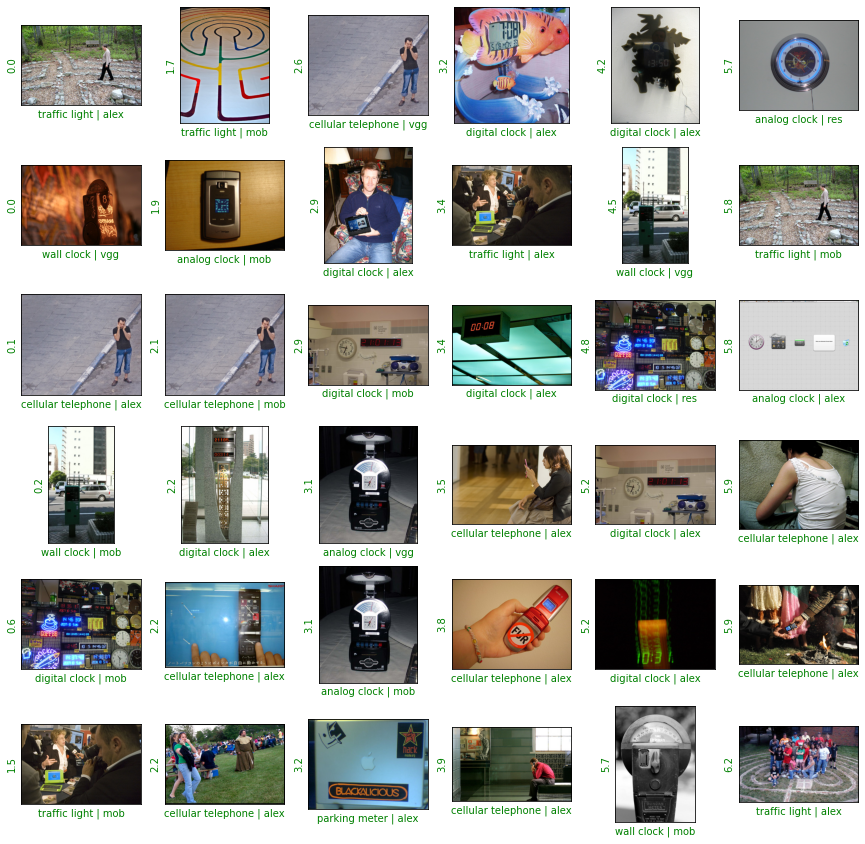

In [37]:
N_image_i = 6
N_image_j = 6
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(21, 15))
for i, idx in enumerate(df_gray["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_dataset.imgs[df_gray.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_gray.loc[idx]['label'] + ' | ' + df_gray.loc[idx]['model'], color='g')
    perf_ = df_gray.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

Let's analyze the accuracy of each models on the same dataset for color versus grayscale images. Here accuracies are displayed as a violin plot to allow a better representation of the models.

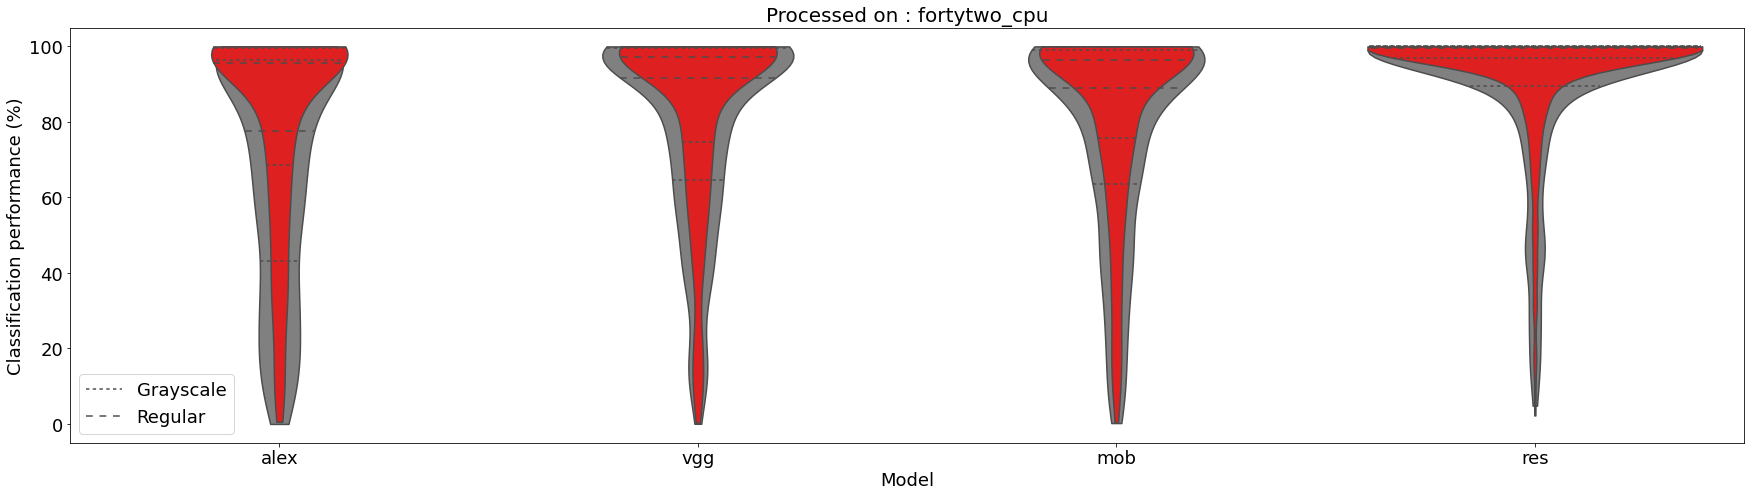

In [38]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, df_, label in zip(['gray', 'red'], [df_gray, df], ['black', 'color']):
    axs = sns.violinplot(x="model", y="perf", data=df_, inner="quartile", cut=0, color=color, alpha=.5)
    axs.set_title('Processed on : ' + HOST + '_' + str(df_['device'][0]), size=20)
    axs.set_ylabel('Classification performance (%)', size=18)
    axs.legend(['Grayscale', 'Regular'], fontsize=18)
    axs.set_xlabel('Model', size=18)

In summary, we have:

In [39]:
for name in models.keys():
    med_perf_orig = np.median(df[df['model']==name]["perf"])
    med_perf = np.median(df_gray[df_gray['model']==name]["perf"])
    print(f'For the {name} model, the median clasification performance = {med_perf:.2f} % (color =  {med_perf_orig:.2f} % )' )

For the alex model, the median clasification performance = 77.46 % (color =  95.60 % )
For the vgg model, the median clasification performance = 91.54 % (color =  97.13 % )
For the mob model, the median clasification performance = 88.97 % (color =  96.41 % )
For the res model, the median clasification performance = 99.63 % (color =  99.97 % )


In [40]:
for name in models.keys():
    med_perf_orig = np.median(df[df['model']==name]["time"])
    med_perf = np.median(df_gray[df_gray['model']==name]["time"])
    print(f'For the {name} model, the median computation time  =  {med_perf:.3f} s  (color =  {med_perf_orig:.3f} s )' )

For the alex model, the median computation time  =  0.075 s  (color =  0.086 s )
For the vgg model, the median computation time  =  0.403 s  (color =  0.420 s )
For the mob model, the median computation time  =  0.054 s  (color =  0.062 s )
For the res model, the median computation time  =  0.556 s  (color =  0.609 s )


In [41]:
for name in models.keys():
    med_perf_orig = np.median(df[df['model']==name]["fps"])
    med_perf = np.median(df_gray[df_gray['model']==name]["fps"])
    print(f'For the {name} model, the median fps  =  {med_perf:.3f} Hz (color =  {med_perf_orig:.3f} Hz )' )

For the alex model, the median fps  =  13.407 Hz (color =  11.637 Hz )
For the vgg model, the median fps  =  2.481 Hz (color =  2.382 Hz )
For the mob model, the median fps  =  18.513 Hz (color =  16.218 Hz )
For the res model, the median fps  =  1.799 Hz (color =  1.641 Hz )


The grayscale transformation on the input seems to degrade the recognition accuracy for all the models as they perform on the same dataset. There is only a modest gain in processing speed.

# Final synthesis

We have run the benchmark on various platforms, with or without GPU. Let's summarize the main message.


In [42]:
HOSTS = {'fortytwo':                     'iMac pro 36 cores    ', 
         'ai-int-desktop':               'NVIDIA Jetson TX2    ',
         'jnjer-HP-Pavilion-Notebook' :  'Intel core i5 7th gen'
        # 'inv-ope-de06': 'Dell station with GTX Tegra',
        }
for HOST in  HOSTS:
    print('HOST:', HOST, ', device:', HOSTS[HOST])

HOST: fortytwo , device: iMac pro 36 cores    
HOST: ai-int-desktop , device: NVIDIA Jetson TX2    
HOST: jnjer-HP-Pavilion-Notebook , device: Intel core i5 7th gen


We verify that the classification performance is similar on different machines (as these algorithms are deterministic):

In [43]:
for i in [1,3]:
    print('> For experiment ', i)
    for name in models.keys():
        print('>>> For model ', name)
        for HOST in HOSTS:
            filename = f'results/{datetag}_results_{i}_{HOST}.json'
            #print(filename)
            df = pd.read_json(filename)
            med_perf = np.median(df[df['model']==name]["perf"])
            print(f'On host {HOSTS[HOST]}, for the {name} model, the median clasification performance =  {med_perf:.2f} %' )

> For experiment  1
>>> For model  alex
On host iMac pro 36 cores    , for the alex model, the median clasification performance =  95.60 %
On host NVIDIA Jetson TX2    , for the alex model, the median clasification performance =  98.55 %
On host Intel core i5 7th gen, for the alex model, the median clasification performance =  98.12 %
>>> For model  vgg
On host iMac pro 36 cores    , for the vgg model, the median clasification performance =  97.13 %
On host NVIDIA Jetson TX2    , for the vgg model, the median clasification performance =  99.65 %
On host Intel core i5 7th gen, for the vgg model, the median clasification performance =  99.53 %
>>> For model  mob
On host iMac pro 36 cores    , for the mob model, the median clasification performance =  96.41 %
On host NVIDIA Jetson TX2    , for the mob model, the median clasification performance =  99.38 %
On host Intel core i5 7th gen, for the mob model, the median clasification performance =  99.21 %
>>> For model  res
On host iMac pro 3

But that the computation time varies greatly depending on the platform:

In [44]:
for i in [1,3]:
    print('> For experiment ', i)
    for name in models.keys():
        print('>>> For model ', name)
        for HOST in HOSTS:
            filename = f'results/{datetag}_results_{i}_{HOST}.json'
            df = pd.read_json(filename)
            med_perf = np.median(df[df['model']==name]["time"])
            print(f'On host {HOSTS[HOST]}, for the {name} model, the median computation time  =  {med_perf:.3f} s' )

> For experiment  1
>>> For model  alex
On host iMac pro 36 cores    , for the alex model, the median computation time  =  0.086 s
On host NVIDIA Jetson TX2    , for the alex model, the median computation time  =  0.024 s
On host Intel core i5 7th gen, for the alex model, the median computation time  =  0.032 s
>>> For model  vgg
On host iMac pro 36 cores    , for the vgg model, the median computation time  =  0.420 s
On host NVIDIA Jetson TX2    , for the vgg model, the median computation time  =  0.101 s
On host Intel core i5 7th gen, for the vgg model, the median computation time  =  0.338 s
>>> For model  mob
On host iMac pro 36 cores    , for the mob model, the median computation time  =  0.062 s
On host NVIDIA Jetson TX2    , for the mob model, the median computation time  =  0.072 s
On host Intel core i5 7th gen, for the mob model, the median computation time  =  0.035 s
>>> For model  res
On host iMac pro 36 cores    , for the res model, the median computation time  =  0.609 s


From experiment 2, we check on the different hosts the same trend of classification performance for different image size (as a note, the run on the Jetson filed for resnet at an image size of 64) :

In [45]:
for name in models.keys():
    print('> For model ', name)
    for size in image_sizes :
        print(f'>> Image size : {size}')
        for HOST in HOSTS:
            filename = f'results/{datetag}_results_2_{HOST}.json'
            df = pd.read_json(filename)
            med_perf = np.median(df[df['model']==name][df['image_size']==size]["perf"])
            print(f'On host {HOSTS[HOST]}, for the {name} model, the median clasification performance =  {med_perf:.2f} %' )

> For model  alex
>> Image size : 64
On host iMac pro 36 cores    , for the alex model, the median clasification performance =  14.78 %
On host NVIDIA Jetson TX2    , for the alex model, the median clasification performance =  34.21 %


<ipython-input-45-76a6c7d60581>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_perf = np.median(df[df['model']==name][df['image_size']==size]["perf"])


On host Intel core i5 7th gen, for the alex model, the median clasification performance =  33.94 %
>> Image size : 128
On host iMac pro 36 cores    , for the alex model, the median clasification performance =  91.61 %
On host NVIDIA Jetson TX2    , for the alex model, the median clasification performance =  97.55 %
On host Intel core i5 7th gen, for the alex model, the median clasification performance =  97.16 %
>> Image size : 256
On host iMac pro 36 cores    , for the alex model, the median clasification performance =  94.34 %
On host NVIDIA Jetson TX2    , for the alex model, the median clasification performance =  98.40 %
On host Intel core i5 7th gen, for the alex model, the median clasification performance =  98.03 %
>> Image size : 512
On host iMac pro 36 cores    , for the alex model, the median clasification performance =  69.53 %
On host NVIDIA Jetson TX2    , for the alex model, the median clasification performance =  77.38 %
On host Intel core i5 7th gen, for the alex model

Note that performance may varry due to the difference between the datasets automatically extracted on the various machines.